<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial

Adapted by Iñaki Diaz from
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [41]:
# Setup environment
!apt-get -qq install xxd
#!pip install pandas numpy matplotlib
#!pip install tensorflow==2.0.0-rc1

## Upload Data

1. Open the panel on the left side of Colab by clicking on the three bars icon
1. Select the files tab
1. Drag `fall.csv` and `sit.csv` files from your computer to the tab to upload them into colab.

## Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

/tmp/ipython-input-1489602219.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipython-input-1489602219.py:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipython-input-1489602219.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


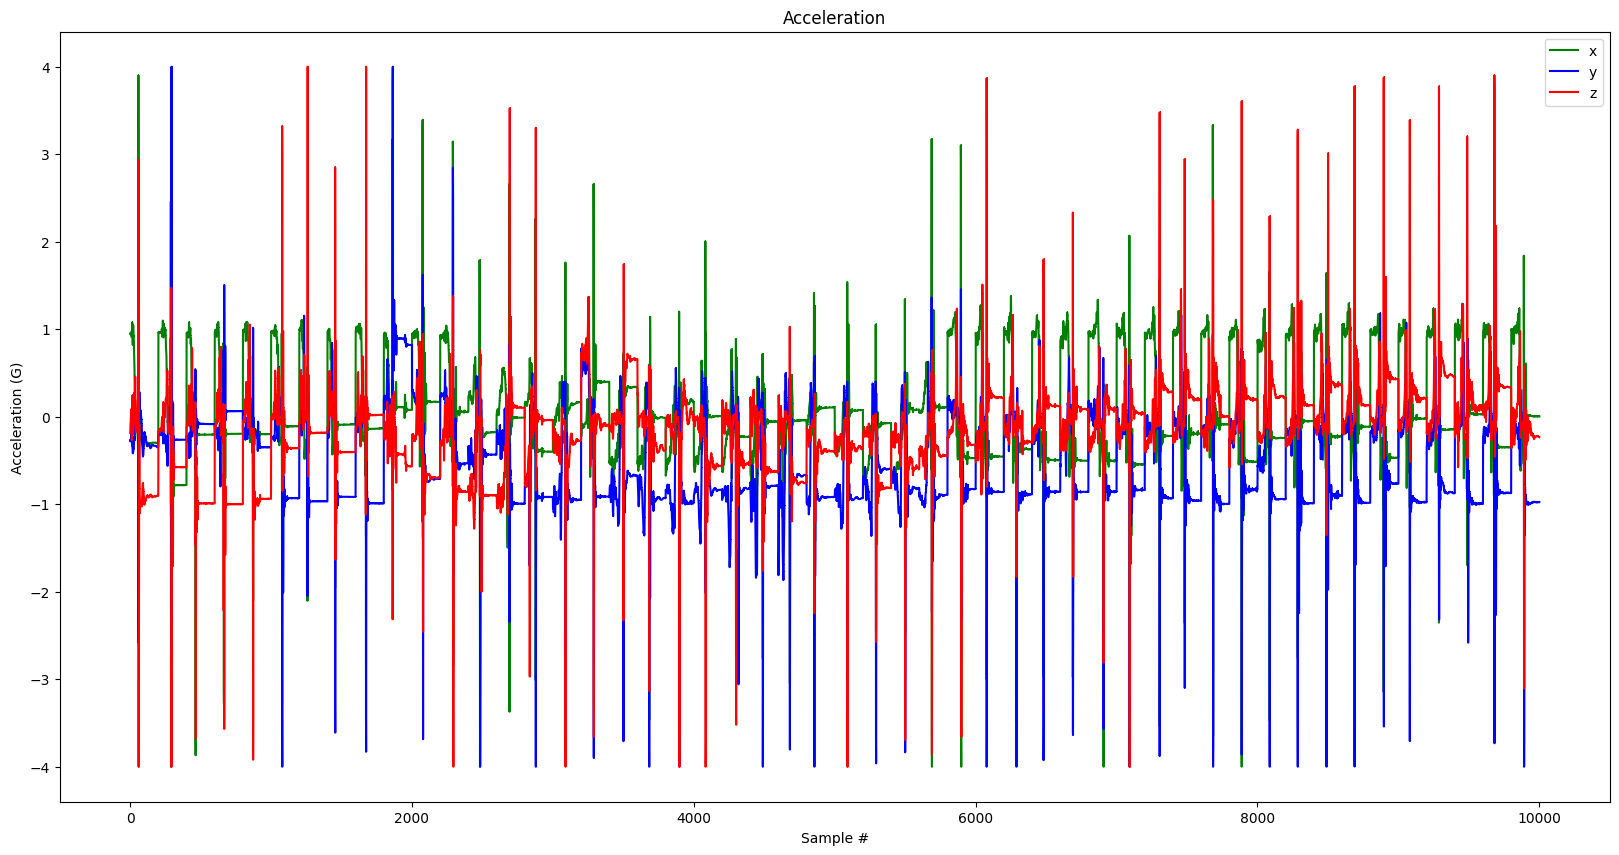

/tmp/ipython-input-1489602219.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
/tmp/ipython-input-1489602219.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
/tmp/ipython-input-1489602219.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


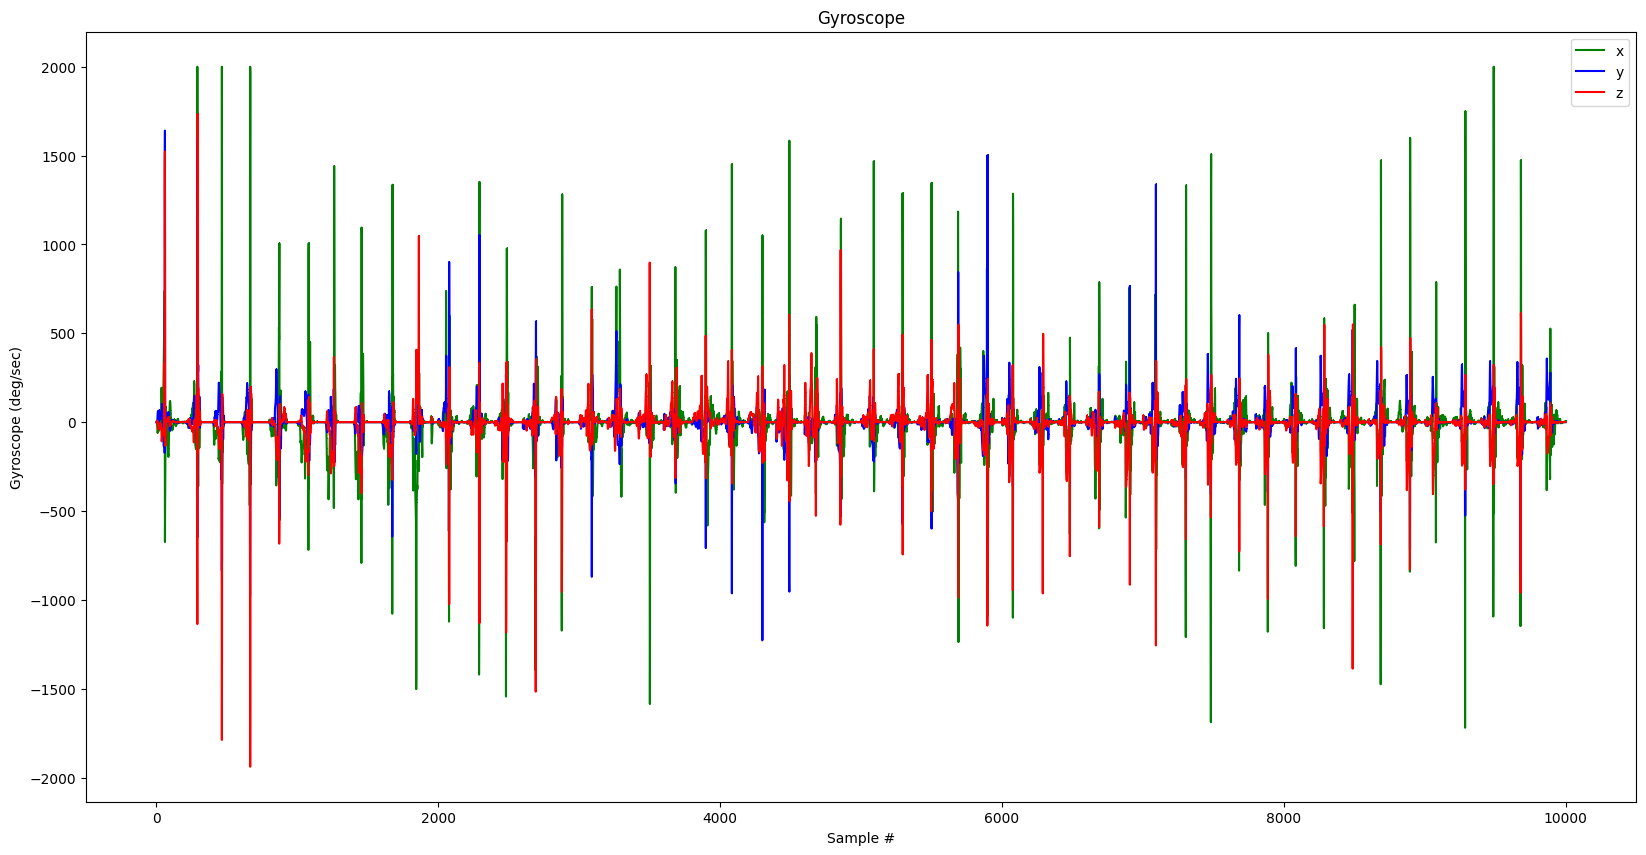

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "fall.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


## Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "fall",
    "lie_down",
    "walk",
    "sit",
]

SAMPLES_PER_GESTURE = 200

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.19.0

Processing index 0 for gesture 'fall'.
	There are 50 recordings of the fall gesture.
Processing index 1 for gesture 'lie_down'.
	There are 50 recordings of the lie_down gesture.
Processing index 2 for gesture 'walk'.
	There are 50 recordings of the walk gesture.
Processing index 3 for gesture 'sit'.
	There are 50 recordings of the sit gesture.
Data set parsing and preparation complete.


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np

# --- shuffle global primero ---
idx = np.arange(len(inputs))
np.random.shuffle(idx)

inputs = inputs[idx]
outputs = outputs[idx]

# --- labels para stratify ---
labels = np.argmax(outputs, axis=1)

# --- split estratificado ---
inputs_train, inputs_temp, outputs_train, outputs_temp = train_test_split(
    inputs,
    outputs,
    test_size=0.4,
    stratify=labels,
    random_state=SEED
)

labels_temp = np.argmax(outputs_temp, axis=1)

inputs_validate, inputs_test, outputs_validate, outputs_test = train_test_split(
    inputs_temp,
    outputs_temp,
    test_size=0.5,
    stratify=labels_temp,
    random_state=SEED
)

print("Shuffle + Stratified split complete")

Shuffle + Stratified split complete


In [68]:
print("Train:", np.sum(outputs_train, axis=0))
print("Val:", np.sum(outputs_validate, axis=0))
print("Test:", np.sum(outputs_test, axis=0))

Train: [30. 30. 30. 30.]
Val: [10. 10. 10. 10.]
Test: [10. 10. 10. 10.]


In [69]:
print(outputs[:10])

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [71]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# callback: guardar mejor modelo según val_loss
checkpoint = ModelCheckpoint(
    "best_model.keras",      # archivo de salida
    monitor="val_loss",      # métrica a mirar
    save_best_only=True,     # solo guarda si mejora
    mode="min",              # menor val_loss = mejor
    verbose=1
)

# build model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1200,)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')
])

model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# train + callback
history = model.fit(
    inputs_train,
    outputs_train,
    epochs=500,
    batch_size=8,
    validation_data=(inputs_validate, outputs_validate),
    callbacks=[checkpoint]
)

Epoch 1/500
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3034 - loss: 1.4565
Epoch 1: val_loss improved from inf to 1.38740, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.3015 - loss: 1.4511 - val_accuracy: 0.2500 - val_loss: 1.3874
Epoch 2/500
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2154 - loss: 1.3863 
Epoch 2: val_loss improved from 1.38740 to 1.38660, saving model to best_model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2215 - loss: 1.3910 - val_accuracy: 0.2500 - val_loss: 1.3866
Epoch 3/500
12/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2359 - loss: 1.3879  
Epoch 3: val_loss did not improve from 1.38660
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2333 - loss: 1.3894 - val_accuracy: 0.2500 - val_loss: 1.3887
Epoch 4/500
 8/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2452 - loss: 1.3820 
Epoch 4: val_loss did not improve from 1.38660
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accura

In [72]:
best_model = tf.keras.models.load_model("best_model.keras")

In [73]:
print(best_model.input_shape)

(None, 1200)


## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

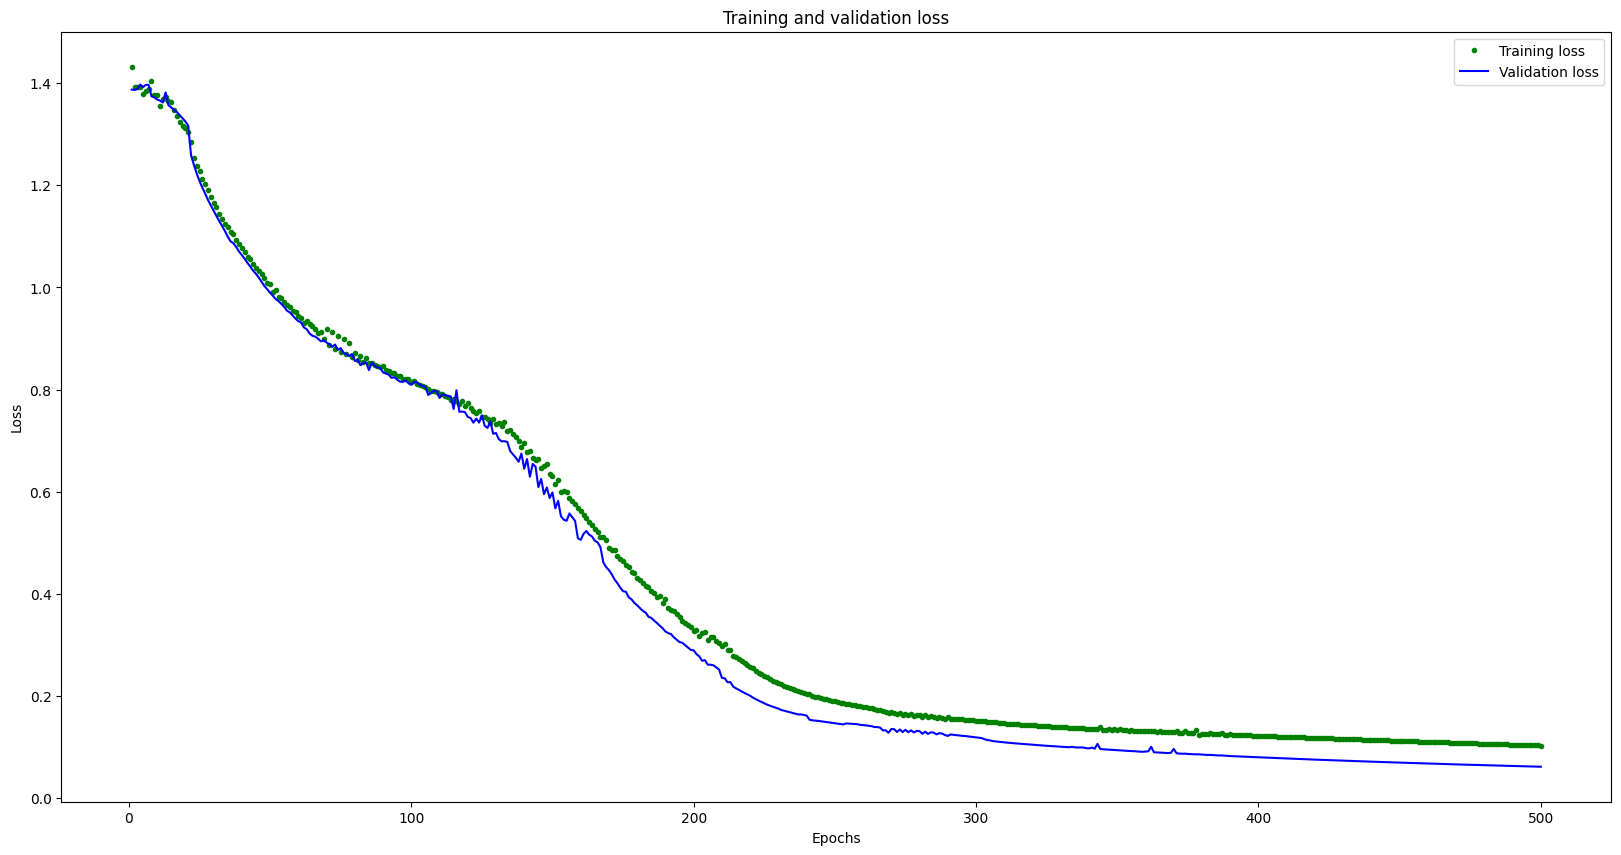

[20.0, 10.0]


In [74]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

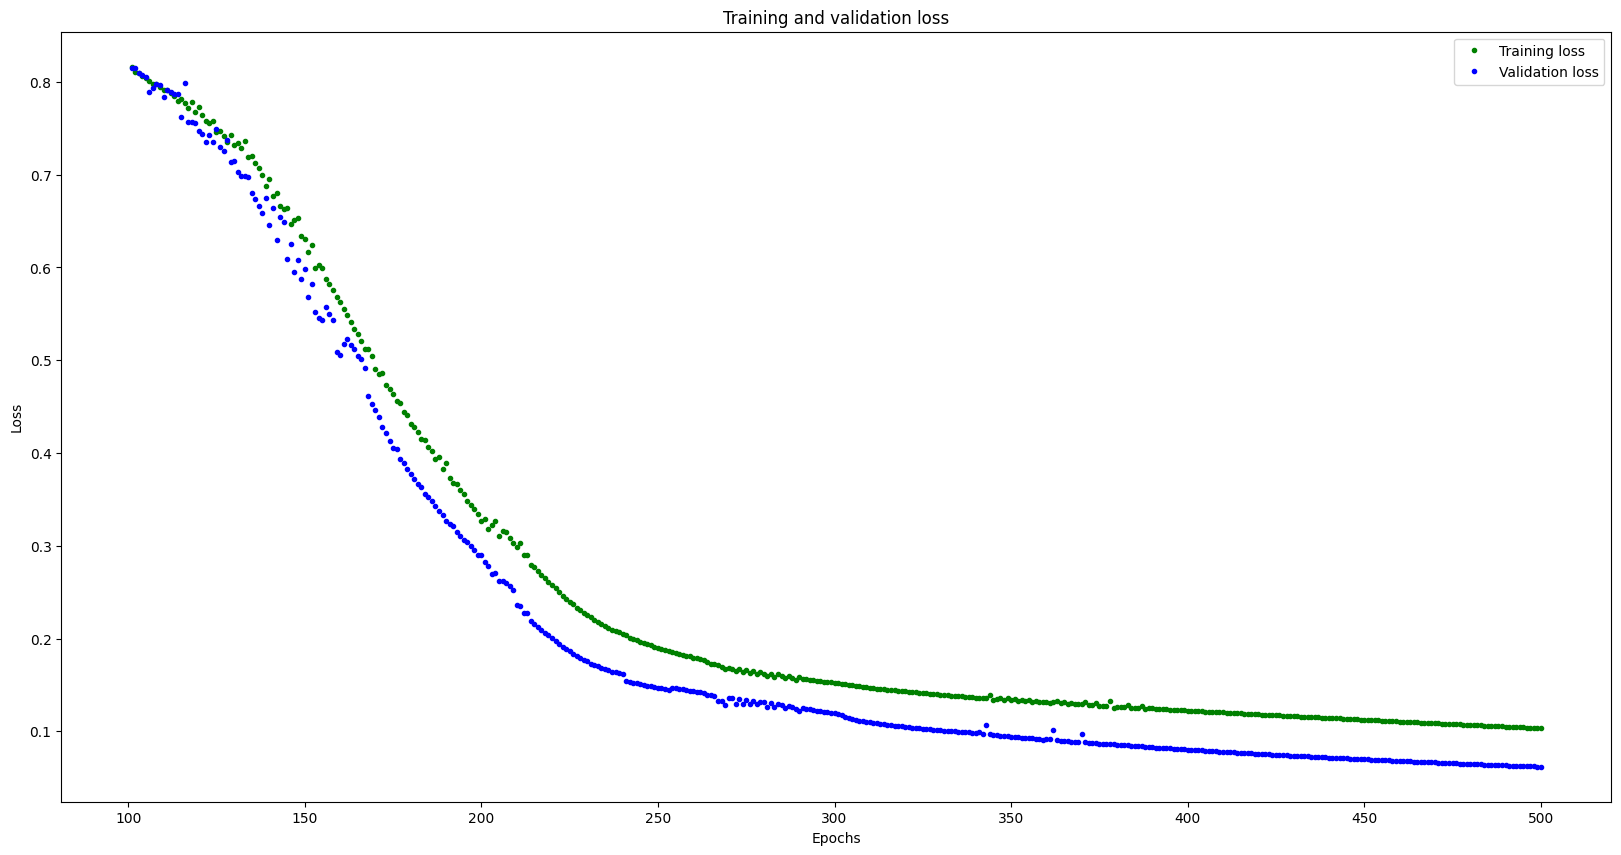

In [75]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Run with Test Data
Put our test data into the model and plot the predictions


In [76]:
predictions = best_model.predict(inputs_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Confusion matrix:
[[10  0  0  0]
 [ 0  9  1  0]
 [ 0  0 10  0]
 [ 0  0  1  9]]


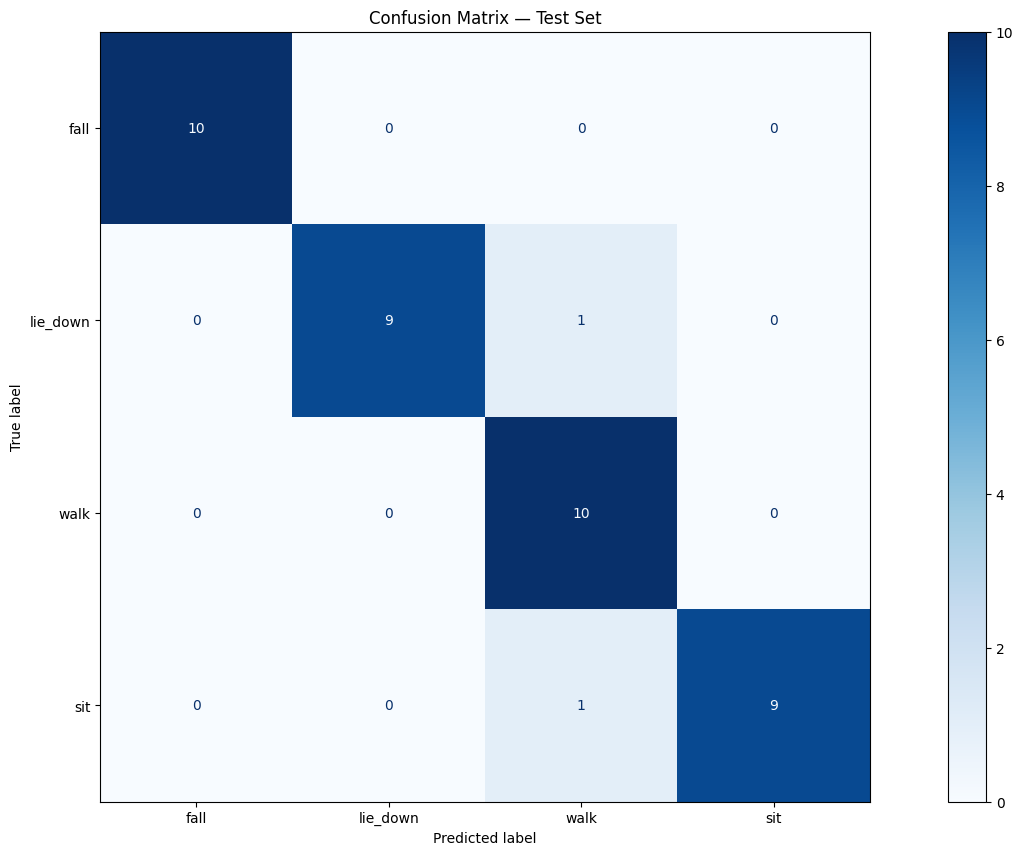

Test accuracy: 0.95

Classification report:
              precision    recall  f1-score   support

        fall       1.00      1.00      1.00        10
    lie_down       1.00      0.90      0.95        10
        walk       0.83      1.00      0.91        10
         sit       1.00      0.90      0.95        10

    accuracy                           0.95        40
   macro avg       0.96      0.95      0.95        40
weighted avg       0.96      0.95      0.95        40



In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# convertir probabilidades → clase predicha
y_pred = np.argmax(predictions, axis=1)

# convertir one-hot real → clase real
y_true = np.argmax(outputs_test, axis=1)

# matriz de confusión
cm = confusion_matrix(y_true, y_pred)

print("Confusion matrix:")
print(cm)

# gráfico
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=GESTURES
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Test Set")
plt.show()

# accuracy real en test
print("Test accuracy:", accuracy_score(y_true, y_pred))

# reporte detallado por clase
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=GESTURES))

## Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [80]:
print(best_model.input_shape)

(None, 1200)


In [81]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Saved artifact at '/tmp/tmp91zz31go'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 1200), dtype=tf.float32, name='input_layer_15')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137768998888720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137768998887376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137768998883152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137768998886800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137768998879696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137768998884688: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 118852 bytes


In [82]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

print(interpreter.get_input_details())

[{'name': 'serving_default_input_layer_15:0', 'index': 0, 'shape': array([   1, 1200], dtype=int32), 'shape_signature': array([  -1, 1200], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [83]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 732,956 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Classifying IMU Data

Place the model.h file in the same Arduino directory where the classifier is working.
